# <font color='green'>Combining bit-flip and phase-flip repetition codes: Shor's 9-qubit code</font>

So far, we have seen how to encode qubits to protect from bit-flip and phase-flip errors, but only one of these two kinds of errors at a time. The Shor code, Peter Shor in 1995 [1], was the first quantum error-correcting code that could protect against both bit-flip and phase-flip errors. It achieves this through a clever technique called **concatenation** -- essentially nesting one code inside another.

Here, we build the Shor code from scratch, and simulate the logical error probability of the Shor code for various physical error probabilities.

## <font color='blue'>Encoding procedure</font>

The Shor code combines the encoding schemes of both repetition codes that we've seen so far using 9 physical qubits to encode 1 logical qubit.

1. First, encode against bit-flip errors (like the 3-qubit bit-flip code), by encoding $\vert0\rangle \rightarrow \vert000\rangle$ and $\vert1\rangle \rightarrow \vert111\rangle$.
2. Then, encode each qubit within the 3 blocks against phase-flip errors (like in the 3-qubit phase-flip code), by encoding $\vert0\rangle \rightarrow \frac{\vert000\rangle + \vert111\rangle}{\sqrt{2}}$ and $\vert1\rangle \rightarrow \frac{\vert000\rangle - \vert111\rangle}{\sqrt{2}}$ within each block.

This gives us 3 blocks of 3 qubits, for a total of 3 × 3 = 9 physical qubits which will serve as the data qubits.

![img](images/shor-encoding.png)

The logical states are then

$$
\vert0\rangle_L = \left(\frac{\vert000\rangle + \vert111\rangle}{\sqrt{2}}\right)_\text{block 1}\otimes\left(\frac{\vert000\rangle + \vert111\rangle}{\sqrt{2}}\right)_\text{block 2}\otimes\left(\frac{\vert000\rangle + \vert111\rangle}{\sqrt{2}}\right)_\text{block 3}
$$

and

$$
\vert1\rangle_L = \left(\frac{\vert000\rangle - \vert111\rangle}{\sqrt{2}}\right)_\text{block 1}\otimes\left(\frac{\vert000\rangle - \vert111\rangle}{\sqrt{2}}\right)_\text{block 2}\otimes\left(\frac{\vert000\rangle - \vert111\rangle}{\sqrt{2}}\right)_\text{block 3}
$$

and the logical superposition states follow as usual:

$$
\vert+\rangle_L = \frac{\vert0\rangle_L + \vert1\rangle_L}{\sqrt{2}}
$$

and

$$
\vert-\rangle_L = \frac{\vert0\rangle_L - \vert1\rangle_L}{\sqrt{2}}
$$

In [1]:
import numpy as np, random
import matplotlib.pyplot as plotter; plotter.rcParams['font.family'] = 'Monospace'
import cirq
from math import comb, ceil, floor
from myMWPM import MWPMDecoder1D
from tqdm import tqdm
from phase_flip_rep_codes import get_binary_representation

In [2]:
def create_shor_encoder(block_size = 3):

    qubits = cirq.LineQubit.range(block_size * block_size)
    circuit = cirq.Circuit()
    # outer phase encoding
    for i in range(1, block_size):
        circuit.append([
            cirq.CNOT(qubits[0], qubits[block_size * i]),
    ])

    circuit.append(cirq.Moment(
                cirq.H.on_each(*[qubits[i*block_size] for i in range(block_size)])
        )
    )
    
    # inner bit-flip encoding
    for i in range(block_size):
        block_start = i * block_size
        for j in range(1, block_size):
            circuit.append([
                cirq.CNOT(qubits[block_start], qubits[block_start + j]),
            ])
    return circuit

In [3]:
encoder = create_shor_encoder(block_size = 3)
print(encoder)

0: ───@───@───H───@───@───
      │   │       │   │
1: ───┼───┼───────X───┼───
      │   │           │
2: ───┼───┼───────────X───
      │   │
3: ───X───┼───H───@───@───
          │       │   │
4: ───────┼───────X───┼───
          │           │
5: ───────┼───────────X───
          │
6: ───────X───H───@───@───
                  │   │
7: ───────────────X───┼───
                      │
8: ───────────────────X───


## <font color='blue'>Extracting syndromes</font>

As before, we will use syndrome qubits to extract syndromes. Since there are 9 data qubits, we will need to do 8 pairwise parity checks and therefore require 8 additional syndrome qubits, for a total of 17 physical qubits. These 8 pairwise parity checks are composed of two kinds: 6 within-block parity checks to ensure consistency within each block, and 2 block-pair-wise parity checks to ensure consistency across the 3 blocks.

### <font color='red'>Parity checks within blocks</font>

Within each block, we will run $Z_iZ_{i+1}$ parity checks to ensure bitwise consistency within that block, similar to bit-flip repetition codes. Since there are 3 blocks in total, each of which will need 2 such parity checks, we will need a total of 6 syndrome qubits to do this work.

In [4]:
def get_shor_bitflip_syndrome_measurement(block_size = 3):
    
    circuit = cirq.Circuit()
    data_qubits = cirq.LineQubit.range(block_size * block_size)
    bitflip_syndrome_start_index = len(data_qubits)
    bitflip_syndrome_qubits = cirq.LineQubit.range(bitflip_syndrome_start_index, bitflip_syndrome_start_index + (block_size - 1)*block_size)
    
    for block_index in range(block_size):
        for within_block_index in range(block_size-1):
            data_qubit_index = block_index * block_size + within_block_index
            syndrome_index = block_index * (block_size-1) + within_block_index
            circuit.append([
                cirq.CNOT(data_qubits[data_qubit_index], bitflip_syndrome_qubits[syndrome_index]),
                cirq.CNOT(data_qubits[data_qubit_index + 1], bitflip_syndrome_qubits[syndrome_index]),
            ])
        circuit.append(cirq.Moment(cirq.I.on_each(*data_qubits)))
    circuit.append(cirq.measure(*bitflip_syndrome_qubits, key = 'bitflip-syndrome'))

    return circuit

In [5]:
bitflip_syndrome_meas = get_shor_bitflip_syndrome_measurement(block_size = 3)
print(bitflip_syndrome_meas)

0: ────@───────────────I───────────────────I───────────────────I───────────────────────
       │
1: ────┼───@───@───────I───────────────────I───────────────────I───────────────────────
       │   │   │
2: ────┼───┼───┼───@───I───────────────────I───────────────────I───────────────────────
       │   │   │   │
3: ────┼───┼───┼───┼───I───@───────────────I───────────────────I───────────────────────
       │   │   │   │       │
4: ────┼───┼───┼───┼───I───┼───@───@───────I───────────────────I───────────────────────
       │   │   │   │       │   │   │
5: ────┼───┼───┼───┼───I───┼───┼───┼───@───I───────────────────I───────────────────────
       │   │   │   │       │   │   │   │
6: ────┼───┼───┼───┼───I───┼───┼───┼───┼───I───@───────────────I───────────────────────
       │   │   │   │       │   │   │   │       │
7: ────┼───┼───┼───┼───I───┼───┼───┼───┼───I───┼───@───@───────I───────────────────────
       │   │   │   │       │   │   │   │       │   │   │
8: ────┼───┼───┼───┼───I───┼───┼───┼

### <font color='red'>Parity checks across blocks</font>

We will also run parity checks to ensure _phase_ consistency across all 3 blocks. To do so, we run $X_iX_{i+1}$ parity checks across blocks. Note that when $Z$ errors occur within each block, only an odd number of such errors causes a phase consistency across blocks (since $Z_i\vert111\rangle = -\vert111\rangle$ and $-Z_j\vert111\rangle = \vert111\rangle$ for any $i$ and $j$ within a block). One parity check will measure the phase consistency between blocks 0 and 1 (by running $X_0X_1X_2X_3X_4X_5$), and another will measure the phase consistency between blocks 0 and 2 (by running $X_0X_1X_2X_6X_7X_8$). If two blocks are inconsistent but we know that they are, we can simply apply a single $Z$ gate in one of the blocks to bring them back to consistency and avoid a logical error.

Note that there are two methods for running an $X_iX_j$ parity check (see [Dan Browne's lecture notes, section 1.3.9](https://sites.google.com/site/danbrowneucl/teaching/lectures-on-topological-codes-and-quantum-computation). In one method, we initialize the syndrome qubits in the Hadamard basis, run controlled-$X$ gates from the syndrome qubits to the data qubits, and then measure the syndrome in the Hadamard basis. The circuit identity $HZH = X$ can be used to transform this method into the second: apply $H$ gates to all data qubits, and run controlled-$X$ gates from the data qubits to the syndrome qubits.

We will use the latter method below.

In [6]:
def get_shor_phaseflip_syndrome_measurement(block_size = 3):
    
    circuit = cirq.Circuit()
    data_qubits = cirq.LineQubit.range(block_size * block_size)
    bitflip_syndrome_start_index = len(data_qubits)
    bitflip_syndrome_qubits = cirq.LineQubit.range(bitflip_syndrome_start_index, bitflip_syndrome_start_index + (block_size - 1) * block_size)
    phaseflip_syndrome_start_index = len(data_qubits) + len(bitflip_syndrome_qubits)
    phaseflip_syndrome_qubits = cirq.LineQubit.range(phaseflip_syndrome_start_index, phaseflip_syndrome_start_index + (block_size - 1))

    circuit.append(cirq.Moment(cirq.H.on_each(*data_qubits)))
    # block 0 to both all syndrome qubits. The data qubits of block 0 are indexed 0 to block_size
    for data_qubit_index in range(block_size):
        for phaseflip_syndrome_index in range(block_size - 1):
            circuit.append(
                cirq.CNOT(data_qubits[data_qubit_index], phaseflip_syndrome_qubits[phaseflip_syndrome_index])
            )
    circuit.append(cirq.Moment(cirq.I.on_each(*phaseflip_syndrome_qubits)))


    # all other blocks to one syndrome at a time each
    for block_index in range(1, block_size):
        data_qubit_start_index = block_size * block_index
        for data_qubit_index in range(data_qubit_start_index, data_qubit_start_index + block_size):
            circuit.append(
                cirq.CNOT(data_qubits[data_qubit_index], phaseflip_syndrome_qubits[block_index - 1])
            )
        circuit.append(cirq.Moment(cirq.I.on_each(*phaseflip_syndrome_qubits)))

    circuit.append(cirq.Moment(cirq.H.on_each(*data_qubits)))
    circuit.append(cirq.measure(*phaseflip_syndrome_qubits, key = 'phaseflip-syndrome'))
   
    return circuit

In [7]:
phaseflip_syndrome_meas = get_shor_phaseflip_syndrome_measurement(block_size = 3)
print(phaseflip_syndrome_meas)

               ┌──┐   ┌──┐
0: ────H───@────@────────────────────────────────────────────────────H─────────────────────────
           │    │
1: ────H───┼────┼@─────@─────────────────────────────────────────────H─────────────────────────
           │    ││     │
2: ────H───┼────┼┼─────┼@────@───────────────────────────────────────H─────────────────────────
           │    ││     ││    │
3: ────H───┼────┼┼─────┼┼────┼───────@───────────────────────────────H─────────────────────────
           │    ││     ││    │       │
4: ────H───┼────┼┼─────┼┼────┼───────┼───@───────────────────────────H─────────────────────────
           │    ││     ││    │       │   │
5: ────H───┼────┼┼─────┼┼────┼───────┼───┼───@───────────────────────H─────────────────────────
           │    ││     ││    │       │   │   │
6: ────H───┼────┼┼─────┼┼────┼───────┼───┼───┼───────@───────────────H─────────────────────────
           │    ││     ││    │       │   │   │       │
7: ────H───┼────┼┼─────┼┼────┼───────┼───┼─

## <font color='blue'>Creating the initial state</font>

We will use standard rotations to initialize the state of the qubit that is protected by the Shor code. An $X$ gate will flip it from $\vert0\rangle$ to $\vert1\rangle$, an $H$ gate will flip $\vert0\rangle$ to $\vert+\rangle$, and a combination of both will flip $\vert0\rangle$ to $\vert-\rangle$ ($\vert-\rangle = ZH\vert0\rangle$).

In [8]:
def create_initial_state(starting_state = '+'):
    
    starting_circuit = cirq.Circuit()
    starting_qubit = cirq.LineQubit(0)

    if starting_state == '0':
        starting_circuit.append(cirq.Moment(cirq.I(starting_qubit)))
    elif starting_state == '1':
        starting_circuit.append(cirq.Moment(cirq.X(starting_qubit)))
    elif starting_state == '+':
        starting_circuit.append(cirq.Moment(cirq.H(starting_qubit)))
    elif starting_state == '-':
        starting_circuit.append(cirq.Moment(cirq.H(starting_qubit)))
        starting_circuit.append(cirq.Moment(cirq.Z(starting_qubit)))

    return starting_circuit

In [9]:
create_initial_state('+')

0: ───H───

## <font color='blue'>Applying noise</font>

As we have seen in the previous chapter on phase-flip repetition codes, we will need to track the errors that we have applied in order to run simulations of the performance of the error-correcting code. The function below applies noise to the relevant data qubits, and then reports which ones it applied.

In [10]:
def create_noise_circuit(p = 0.1, block_size = 3, error_gate = cirq.Z):

    def flip(p):
        return 1 if random.random() < p else 0
    
    noise_circuit = cirq.Circuit()
    data_qubits = cirq.LineQubit.range(block_size * block_size)

    has_error = [flip(p) for _ in range(len(data_qubits))]
    error_indices = [i for i, x in enumerate(has_error) if x == 1]
    errors = []
    for error_index in error_indices:
        noise_circuit.append(error_gate(data_qubits[error_index]))
        errors.append(error_gate)

    return noise_circuit, [error_indices, errors]

## <font color='blue'>Putting it all together</font>

We can now combine all the pieces above into a full run of the Shor code. Once we construct the circuit to encode the state of one qubit into the 9 qubits of the Shor code, apply noise, and run our syndrome checks, we will need to decode the syndrome checks and determine whether a logical error has occurred.

A logical error can happen in two ways:
- If a single $Z$ errors happens within a block, then we will be able to determine the location of that block through the phase consistency checks described above. However, if two $Z$ errors happen in two different blocks, then our phase consistency's majority vote will fail to identify where these errors occurred, leading to a logical error.
- If a single $X$ error occurs within a block, then we will be able to determine its location through the within-block bitwise parity checks described above. However, if two $X$ errors occur within the same block, these within-block parity checks will not be able to identify the correct location since the majority vote within the block fails to identify the flipped data qubit and a logical error occurs.

In [11]:
def get_shor_code_logical_error_probability(p = 0.1, block_size = 3, n_shots = 1000, simulator = cirq.CliffordSimulator(), starting_state = '+', error_gate = cirq.Z):
    starting_circuit = create_initial_state(starting_state = starting_state)
    encoder_circuit = create_shor_encoder(block_size = block_size)
    bitflip_syndrome_circuit = get_shor_bitflip_syndrome_measurement(block_size = block_size)
    phaseflip_syndrome_circuit = get_shor_phaseflip_syndrome_measurement(block_size = block_size)
    decoder = MWPMDecoder1D(num_qubits=block_size)

    num_logical_errors = 0
    for i in range(n_shots):
        full_shor_circuit = cirq.Circuit()
        noise_circuit, noise_applied = create_noise_circuit(p = p, block_size = block_size, error_gate = error_gate)
        full_shor_circuit = starting_circuit + encoder_circuit + noise_circuit + bitflip_syndrome_circuit + phaseflip_syndrome_circuit
        result = simulator.run(full_shor_circuit, repetitions = 1)
        bitflip_syndromes = result.measurements['bitflip-syndrome'][0]
        phaseflip_syndromes = result.measurements['phaseflip-syndrome'][0]
    
        decoded_bitflip_errors = []
        # decoding bit flips
        # we can tell where bitflip errors happened within each block precisely
        for i in range(0, len(bitflip_syndromes), block_size-1):  # Slice list in steps of block_size
            these_syndromes = bitflip_syndromes[i:i+block_size-1]
            withinblock_error_indices = decoder.decode(these_syndromes)
            error_locations = [int(i // (block_size-1))*block_size + x for x in withinblock_error_indices]
            for error_loc in error_locations:
                decoded_bitflip_errors.append([error_loc, cirq.X])
    
        # decoding phase flips
        # we can only tell that phaseflip errors happened within a block, not precisely where
        # but that's OK because a single Z gate will undo the phase error in a block
        block_errors_0 = [0] # assume block 0 has no phase flip error
        block_errors_1 = [1] # assume block 0 has phase flip error
        for j in range(len(phaseflip_syndromes)):
            # assume block 0 has no phase flip error
            block_errors_0.append(0 ^ phaseflip_syndromes[j])
            # assume block 0 has phase flip error
            block_errors_1.append(1 ^ phaseflip_syndromes[j])
        # pick the option with minimum weight
        if sum(block_errors_0) <= sum(block_errors_1):
            block_errors_final = block_errors_0
        else:
            block_errors_final = block_errors_1
        decoded_phaseflip_error_blocks = [i for i, thisblock_error in enumerate(block_errors_final) if thisblock_error == 1]
    
        # decide whether or not a logical error occurred    
        is_logical_error = False
        qubits_with_errors, qubit_errors = noise_applied

        # bitflip errors are checked within each block. if we are unable to detect a bitflip error within a block
        # then a logical error occurs
        for qubit_with_error, qubit_error in zip(qubits_with_errors, qubit_errors):
            if qubit_error == cirq.X:
                if [qubit_with_error, cirq.X] not in decoded_bitflip_errors:
                    is_logical_error = True
                    
        # if we were unable to detect a block where a Z error happened, then a logical error occurs
        for qubit_with_error, qubit_error in zip(qubits_with_errors, qubit_errors):
            if qubit_error == cirq.Z:
                thisqubit_block = qubit_with_error // block_size
                if thisqubit_block not in decoded_phaseflip_error_blocks:
                    is_logical_error = True
                    
        if is_logical_error:
            num_logical_errors += 1
            
    return num_logical_errors * 1./ n_shots

As before, we write a loop to go through several values of physical error probabilities and test the performance of the error-correcting code to those errors.

In [12]:
def get_logical_error_probability_simulated(block_sizes, physical_errors, n_shots, simulator = cirq.CliffordSimulator(), starting_state = '+', error_gate = cirq.Z):
    
    all_logical_errors = []
    for block_size in block_sizes:
        print(f"Simulating block-size-{block_size} Shor code circuits")
        thisblock_size_logicalerrors = []
        for physical_error in tqdm(physical_errors):
            logical_error = get_shor_code_logical_error_probability(
                                p = physical_error,
                                block_size = block_size,
                                n_shots = n_shots,
                                simulator = simulator,
                                starting_state = starting_state,
                                error_gate = error_gate
                            )
            thisblock_size_logicalerrors.append(logical_error)
        all_logical_errors.append(thisblock_size_logicalerrors)

    return all_logical_errors

In [13]:
starting_state = '0'
error_gate = cirq.Z
block_sizes = [3]
physical_errors = np.logspace(-3, 0, 10)  # 10^-3 = 0.001 to 10^0 = 1 in 10 steps

In [14]:
simulator = cirq.CliffordSimulator()
all_logical_errors = get_logical_error_probability_simulated(block_sizes, physical_errors, 
                                                             n_shots = 50000, simulator = simulator,
                                                             starting_state = starting_state, error_gate = error_gate)

Simulating block-size-3 Shor code circuits


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [16:21<00:00, 98.12s/it]


Now, we can derive an analytical expression for the logical error probability using the same arguments that we have previously seen for repetition codes. We will consider the case of $Z$ errors where the initial state is $\vert+\rangle_L$ for simplicity, for the Shor code where the size of each block is $\text{blocksize}$. There are 9 ($\text{blocksize}^2$) data qubits that can experience a $Z$ error. If more than one $Z$ flip occurs, then we will be unable to detect where it happened with our 2 parity checks that compare the blocks.

There are $\binom{9}{0} = 1$ cases where no $Z$ flips occur (with probability $\left(1-p\right)^9$), and $\binom{9}{1} = 9$ cases where one $Z$ flip occurs (with probability $p\left(1-p\right)^8$ each). Any other case leads to a logical error. Then, the probabilty of success is

$$
p_L = 1-p_\text{success} = 1-\binom{\text{blocksize}^2}{0}\left(1-p\right)^9-\binom{\text{blocksize}^2}{1}p\left(1-p\right)^8 = 1 - \left(1-p\right)^9 - 9p\left(1-p\right)^8
$$

This is exactly the same as our previously derived expression

$$
p_L = 1-p_\text{success} =  1-\sum_{n_\text{flips} = 0}^{d/2} \binom{d}{n_\text{flips}}\times p^{n_\text{flips}}\times(1-p)^{d-n_\text{flips}}
$$

where we replace $d$ by $\text{blocksize}^2$ within the sum, since that represents the total number of qubits used in the encoding procedure that could experience errors, but keep the sum running up to at most $\lfloor d/2\rfloor$ since that is the number of flips that will cause a logical error.

In [15]:
def get_logical_error_probability_analytical(block_sizes, physical_errors):
    
    all_analytical_errors = []
    for block_size in block_sizes:
        # analytical_success = 0
        # for i in range(floor(block_size/2.)+1):
        #     analytical_success += comb(block_size**2, i) * physical_errors**i * (1-physical_errors)**(block_size**2-i)
        # analytical_errors = 1-analytical_success
        analytical_errors = 1 - (1-physical_errors)**9 - 9*physical_errors*(1-physical_errors)**8
        all_analytical_errors.append(analytical_errors)

    return all_analytical_errors

In [16]:
all_analytical_errors = get_logical_error_probability_analytical(block_sizes, physical_errors)

In [17]:
def plot_logical_error_probabilities(block_sizes, physical_errors, all_logical_errors, all_analytical_errors, ylim = [1e-3, 1.1]):
    
    plotter.figure(figsize=(10, 8))
    colors = plotter.cm.viridis(np.linspace(0, 0.8, len(block_sizes)))
    
    plotter.loglog(physical_errors, physical_errors, label = 'Unprotected qubit',
                      linewidth=2, linestyle = '--', color='gray',
                      )
    for block_size, logical_errors, analytical_errors, color in zip(block_sizes, all_logical_errors, all_analytical_errors, colors):
        plotter.loglog(physical_errors, logical_errors, label = f'Shor code (block-size = {block_size}) simulated',
                      marker='o', linewidth=2, markersize=8,
                      color=color,
                      )
        plotter.loglog(physical_errors, analytical_errors, label = f'Shor code(block-size = {block_size}) analytical',
                      linewidth=2, linestyle = '--', color=color,
                      )
    
    plotter.legend()
    plotter.xlim([physical_errors.min(), physical_errors.max()])
    plotter.ylim(ylim)
    plotter.xlabel('Physical error probability')
    plotter.ylabel('Logical error probability')
    plotter.tight_layout()
    plotter.show()

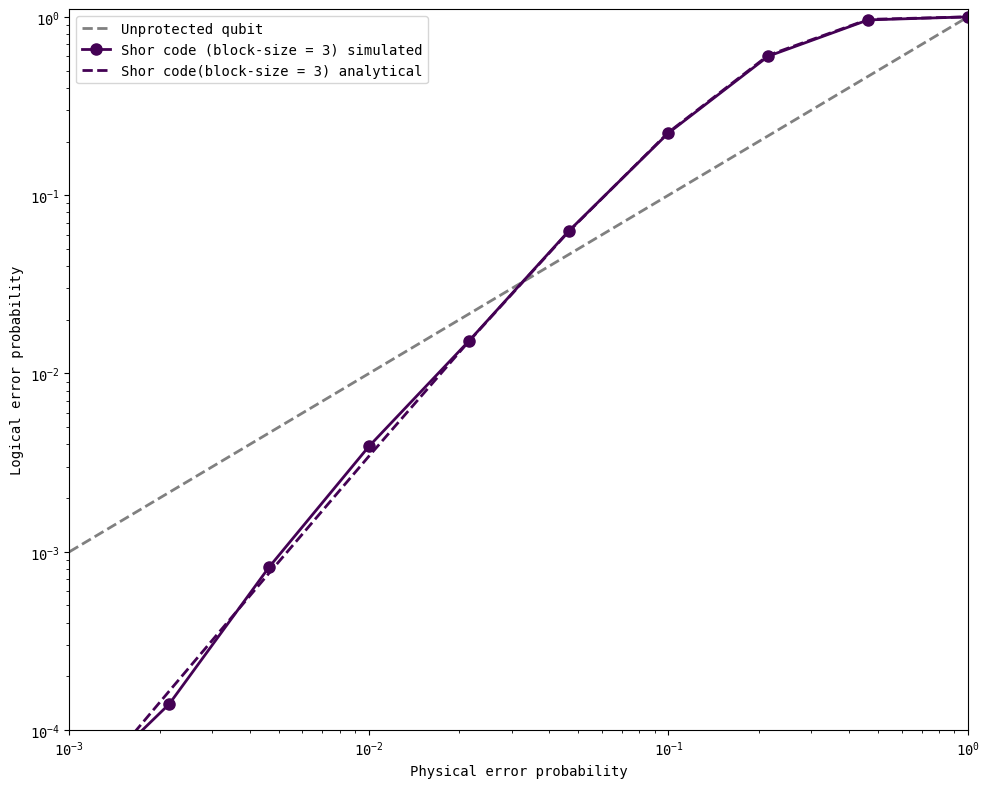

In [18]:
plot_logical_error_probabilities( block_sizes, physical_errors, all_logical_errors, all_analytical_errors, ylim = [1e-4, 1.1])

## <font color='blue'>Faster code performance simulations</font>

In order to test the performance of the Shor code at low errors, we will need to run millions of shots. However, the simulation time above is prohibitively high. To get around this problem, we will use the sampling techniques covered in the previous chapter on running faster circuit simulations. We will first adapt the code above to generate a syndrome table that collects all possible error locations and flags to indicate whether or not they lead to a logical error. Then, we will sample from this syndrome table repeatedly instead of running circuits. The code below samples from the syndrome table using the GPU on the author's laptop. If this is not available for you, the speedup from using a syndrome table should still be significant.

In [19]:
def get_shor_code_logical_error_probability_syndrome_table(block_size = 3, simulator = cirq.CliffordSimulator(), starting_state = '+', error_gate = cirq.Z):
    starting_circuit = create_initial_state(starting_state = starting_state)
    encoder_circuit = create_shor_encoder(block_size = block_size)
    bitflip_syndrome_circuit = get_shor_bitflip_syndrome_measurement(block_size = block_size)
    phaseflip_syndrome_circuit = get_shor_phaseflip_syndrome_measurement(block_size = block_size)
    decoder = MWPMDecoder1D(num_qubits=block_size)

    print(f"Getting syndromes for all possible error locations in block-size {block_size}, |{starting_state}>_L, error gate {error_gate}")
    # first, generate the list of all possible 2^n error locations, n = # data qubits
    data_qubits = cirq.LineQubit.range(block_size**2)
    num_data_qubits = len(data_qubits)
    all_possible_error_locations = []
    for i in tqdm(range(2**num_data_qubits)):
        error_pattern = get_binary_representation(i, num_data_qubits)
        error_locations = np.where(error_pattern)[0].tolist()
        all_possible_error_locations.append(error_locations)

    # then, using these error locations, construct all possible circuits with errors
    all_bitflip_syndromes = []
    all_phaseflip_syndromes = []
    all_circuits = []
    for specific_error_locations in tqdm(all_possible_error_locations):
        full_shor_circuit = starting_circuit + encoder_circuit
        # insert errors
        error_moment = []
        for i in range(num_data_qubits):
            if i in specific_error_locations:
                error_moment.append(error_gate(data_qubits[i]))
        if error_moment:
            full_shor_circuit += cirq.Moment(error_moment) # insert a moment with all errors
        full_shor_circuit += bitflip_syndrome_circuit + phaseflip_syndrome_circuit
        all_circuits.append(full_shor_circuit)

    results = simulator.run_batch(all_circuits, repetitions = 1)
    all_bitflip_syndromes = [results[i][0].measurements['bitflip-syndrome'].tolist()[0] for i in range(len(all_circuits))]
    all_phaseflip_syndromes = [results[i][0].measurements['phaseflip-syndrome'].tolist()[0] for i in range(len(all_circuits))]

    logical_decisions = []
    for bitflip_syndromes, phaseflip_syndromes, applied_error_locations in tqdm(zip(all_bitflip_syndromes, all_phaseflip_syndromes, all_possible_error_locations)):
        decoded_bitflip_errors = []
        # decoding bit flips
        # we can tell where bitflip errors happened within each block precisely
        for i in range(0, len(bitflip_syndromes), block_size-1):  # Slice list in steps of block_size
            these_syndromes = bitflip_syndromes[i:i+block_size-1]
            withinblock_error_indices = decoder.decode(these_syndromes)
            error_locations = [int(i // (block_size-1))*block_size + x for x in withinblock_error_indices]
            for error_loc in error_locations:
                decoded_bitflip_errors.append([error_loc, cirq.X])

        # decoding phase flips
        # we can only tell that phaseflip errors happened within a block, not precisely where
        # but that's OK because a single Z gate will undo the phase error in a block
        block_errors_0 = [0] # assume block 0 has no phase flip error
        block_errors_1 = [1] # assume block 0 has phase flip error
        for j in range(len(phaseflip_syndromes)):
            # assume block 0 has no phase flip error
            block_errors_0.append(0 ^ phaseflip_syndromes[j])
            # assume block 0 has phase flip error
            block_errors_1.append(1 ^ phaseflip_syndromes[j])
        # pick the option with minimum weight
        if sum(block_errors_0) <= sum(block_errors_1):
            block_errors_final = block_errors_0
        else:
            block_errors_final = block_errors_1
        decoded_phaseflip_error_blocks = [i for i, thisblock_error in enumerate(block_errors_final) if thisblock_error == 1]
    
        # decide whether or not a logical error occurred    
        is_logical_error = False

        qubits_with_errors = applied_error_locations
        qubit_errors = [error_gate]*len(qubits_with_errors)
        # bitflip errors are checked within each block. if we are unable to detect a bitflip error within a block
        # then a logical error occurs
        for qubit_with_error, qubit_error in zip(qubits_with_errors, qubit_errors):
            if qubit_error == cirq.X:
                if [qubit_with_error, cirq.X] not in decoded_bitflip_errors:
                    is_logical_error = True
                    
        # if we were unable to detect a block where a Z error happened, then a logical error occurs
        for qubit_with_error, qubit_error in zip(qubits_with_errors, qubit_errors):
            if qubit_error == cirq.Z:
                thisqubit_block = qubit_with_error // block_size
                if thisqubit_block not in decoded_phaseflip_error_blocks:
                    is_logical_error = True
                    
        logical_decisions.append(is_logical_error)

    syndrome_table = {}
    for applied_error_locations, logical_decision in zip(all_possible_error_locations,logical_decisions):
        syndrome_table[tuple(applied_error_locations)] = logical_decision
        
    return syndrome_table

In [20]:
try:
    import mlx.core as mx  # Apple's MLX library for Apple Silicon
except ImportError:
    raise RuntimeError("MLX not available")

def convert_syndrome_table_to_GPU(syndrome_table, n_qubits):    
    # Create a lookup table as a dense array for GPU -- a list containing [error_pattern: is_logical_error] pairs
    syndrome_table_GPU = mx.zeros(2**n_qubits, dtype=mx.bool_)
    for specific_error_locations, is_logical_error in syndrome_table.items():
        # Convert error tuple to binary index
        error_pattern_index = 0
        for qubit_index in specific_error_locations:
            error_pattern_index |= (1 << qubit_index)
        syndrome_table_GPU[error_pattern_index] = is_logical_error
    return syndrome_table_GPU

def simulate_with_syndrome_table_parallel_GPU_mlx(syndrome_table, n_qubits, error_probability, n_shots):
    
    # Convert syndrome table to GPU-friendly format
    syndrome_table_GPU = convert_syndrome_table_to_GPU(syndrome_table, n_qubits)

    total_logical_errors = 0
    batch_size = min(100_000_000, n_shots)  # Process 100M at a time on GPU
    
    shots_processed = 0
    while shots_processed < n_shots:
        current_batch = min(batch_size, n_shots - shots_processed)
        
        # Generate random numbers uniformly from 0 to 1 in an array of shape (current_batch, n_qubits) on GPU
        # Then convert that to an error pattern on the qubits
        error_patterns = mx.random.uniform(shape=(current_batch, n_qubits)) < error_probability
        
        # Convert patterns to indices for lookup
        # The error patterns contain 1 where there is an error, and 0 where there isn't
        # They can be indexed from 0 to 2^n-1 by converting the error pattern tuple into a decimal integer
        # By doing the dot product (2^n-1 2^n-2 2^n-3.... 2^1 2^0) . (error_pattern)
        powers = mx.array([2**i for i in range(n_qubits)])
        error_patterns_indices = mx.sum(error_patterns.astype(mx.int32) * powers, axis=1)
        
        # Lookup whether each index leads to a logical error, and add them all up
        logical_errors_batch = mx.sum(syndrome_table_GPU[error_patterns_indices])
        
        # Transfer result back to CPU
        total_logical_errors += int(logical_errors_batch)
        
        shots_processed += current_batch
            
    return total_logical_errors / n_shots

In [21]:
def get_logical_error_probability_simulated_GPU(block_sizes, physical_errors, n_shots, simulator = cirq.CliffordSimulator(), starting_state = '+', error_gate = cirq.Z):
    
    all_logical_errors = []
    for block_size in block_sizes:
        print(f"Simulating block-size-{block_size} Shor code circuits")
        syndrome_table = get_shor_code_logical_error_probability_syndrome_table(block_size=block_size, starting_state = starting_state, error_gate = error_gate)
        thisblock_size_logicalerrors = []
        for physical_error in tqdm(physical_errors):
            logical_error = simulate_with_syndrome_table_parallel_GPU_mlx(syndrome_table, n_qubits = block_size**2, error_probability = physical_error, n_shots = n_shots)
            thisblock_size_logicalerrors.append(logical_error)
        all_logical_errors.append(thisblock_size_logicalerrors)

    return all_logical_errors

In [22]:
starting_state = '0'
error_gate = cirq.Z
block_sizes = [3]
physical_errors = np.logspace(-5, 0, 10)  # 10^-5 to 10^0 in 10 logsteps

In [23]:
all_logical_errors_0z = get_logical_error_probability_simulated_GPU(block_sizes, physical_errors, 
                                                             n_shots = 1_000_000_000, starting_state = starting_state, error_gate = error_gate)

Simulating block-size-3 Shor code circuits
Getting syndromes for all possible error locations in block-size 3, |0>_L, error gate Z


100%|██████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 6717.23it/s]
512it [00:00, 213510.01it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.68s/it]


In [24]:
starting_state = '0'
error_gate = cirq.X
block_sizes = [3]
physical_errors = np.logspace(-5, 0, 10)  # 10^-5 to 10^0 in 10 logsteps

In [25]:
all_logical_errors_0x = get_logical_error_probability_simulated_GPU(block_sizes, physical_errors, 
                                                             n_shots = 1_000_000_000, starting_state = starting_state, error_gate = error_gate)

Simulating block-size-3 Shor code circuits
Getting syndromes for all possible error locations in block-size 3, |0>_L, error gate X


100%|█████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 20174.96it/s]
512it [00:00, 190110.10it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


In [26]:
starting_state = '+'
error_gate = cirq.Z
block_sizes = [3]
physical_errors = np.logspace(-5, 0, 10)  # 10^-5 to 10^0 in 10 logsteps

In [27]:
all_logical_errors_pz = get_logical_error_probability_simulated_GPU(block_sizes, physical_errors, 
                                                             n_shots = 1_000_000_000, starting_state = starting_state, error_gate = error_gate)

Simulating block-size-3 Shor code circuits
Getting syndromes for all possible error locations in block-size 3, |+>_L, error gate Z


100%|█████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 19386.52it/s]
512it [00:00, 211137.91it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.65s/it]


In [28]:
starting_state = '+'
error_gate = cirq.X
block_sizes = [3]
physical_errors = np.logspace(-5, 0, 10)  # 10^-5 to 10^0 in 10 logsteps

In [29]:
all_logical_errors_px = get_logical_error_probability_simulated_GPU(block_sizes, physical_errors, 
                                                             n_shots = 1_000_000_000, starting_state = starting_state, error_gate = error_gate)

Simulating block-size-3 Shor code circuits
Getting syndromes for all possible error locations in block-size 3, |+>_L, error gate X


100%|█████████████████████████████████████████████████████████████████████████| 512/512 [00:00<00:00, 20051.76it/s]
512it [00:00, 179765.92it/s]
100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:16<00:00,  1.64s/it]


In [30]:
all_analytical_errors = get_logical_error_probability_analytical(block_sizes, physical_errors)

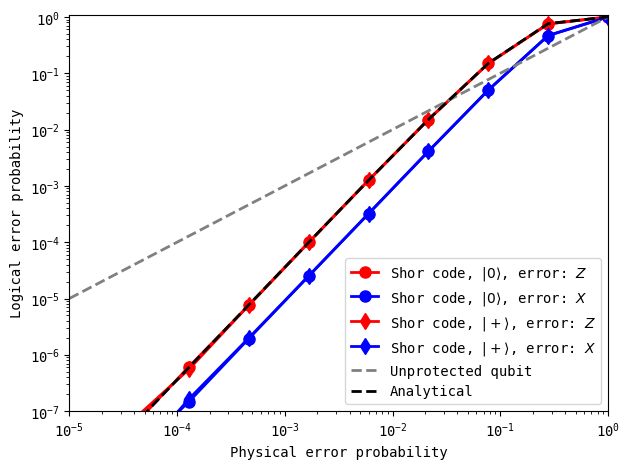

In [31]:
plotter.loglog(physical_errors, all_logical_errors_0z[0], label = r'Shor code, $\vert0\rangle$, error: $Z$', marker='o', linewidth=2, markersize=8, color='red')
plotter.loglog(physical_errors, all_logical_errors_0x[0], label = r'Shor code, $\vert0\rangle$, error: $X$', marker='o', linewidth=2, markersize=8, color='blue')
plotter.loglog(physical_errors, all_logical_errors_pz[0], label = r'Shor code, $\vert+\rangle$, error: $Z$', marker='d', linewidth=2, markersize=8, color='red')
plotter.loglog(physical_errors, all_logical_errors_px[0], label = r'Shor code, $\vert+\rangle$, error: $X$', marker='d', linewidth=2, markersize=8, color='blue')
plotter.loglog(physical_errors, physical_errors, label = "Unprotected qubit", linestyle='--', linewidth=2, color='gray')
plotter.loglog(physical_errors, all_analytical_errors[0], label = "Analytical", linestyle='--', linewidth=2, color='black')
plotter.legend()
plotter.xlim([physical_errors.min(), physical_errors.max()])
plotter.ylim([1e-7, 1.1])
plotter.xlabel('Physical error probability')
plotter.ylabel('Logical error probability')
plotter.tight_layout()
plotter.show()

With faster simulations, we are now able to see that the Shor code can bring logical errors down significantly as the physical error probability lowers. Note that the Shor code is able to suppress both $X$ and $Z$ errors, independent of the starting state. One of the exercises below encourages you to consider why there is a $\sim3\times$ gap between the case of $X$ and $Z$ errors -- this gap does not depend on the starting state.

**Exercises for the reader**

1. Note that the logical error probabilities for $Z$ errors and $X$ errors are $\sim3$x apart in the above figure. Can you explain this difference? (Hint: consider the number of ways that logical errors can occur within blocks and between blocks).
2. Would increasing the block size in the Shor code achieve better results?
3. At what level of physical error probability does the Shor code outperform the bare unprotected qubit?

### <font color='red'>References</font>

1. P. W. Shor, Scheme for reducing decoherence in quantum computer memory. Phys. Rev. A 52, R2493 (1995). [PRA article](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.52.R2493)
2. Calderbank and Shor, Good error-correcting codes exist (1995). [arXiv:quant-ph/9512032](https://arxiv.org/abs/quant-ph/9512032)

---
### Version History
- v0: Sep 12, 2025, [github/@aasfaw](https:github.com/aasfaw)
- v1: Sep 12, 2025, [github/@aasfaw](https:github.com/aasfaw) readability improvements, syndrome check circuits image, faster simulations